# Attrition Prediction IA Project Yoann

## Import

In [96]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
import zipfile

from PIL.ImagePalette import negative
from numpy.array_api import positive
# Import sklearn

from sklearn.compose import make_column_selector
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import SGDClassifier
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import KNNImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

C:\Users\yoann\AppData\Local\Temp\ipykernel_19452\2628820593.py:9: UserWarning: The numpy.array_api submodule is still experimental. See NEP 47.
  from numpy.array_api import positive


## Chargement et exploration des données

In [97]:
# Path to the dataset
src_path = "src/"
general_data_file_path = os.path.join(src_path, "general_data.csv")
employee_survey_data_file_path = os.path.join(src_path, "employee_survey_data.csv")
manager_survey_data_file_path = os.path.join(src_path, "manager_survey_data.csv")
in_time_file_path = os.path.join(src_path + "in_time.csv")
out_time_file_path = os.path.join(src_path + "out_time.csv")

# Load the dataset
general_data = pd.read_csv(general_data_file_path)
employee_survey_data = pd.read_csv(employee_survey_data_file_path)
manager_survey_data = pd.read_csv(manager_survey_data_file_path)
in_time_data = pd.read_csv(os.path.join(src_path, "in_time.csv"))
out_time_data = pd.read_csv(os.path.join(src_path, "out_time.csv"))

## Correction des noms de colonnes

Nous constatons que la première colonne des jeux de données in_time_data et out_time_data est nommée Unnamed: 0. Nous allons la renommer en EmployeeID pour une meilleure lisibilité.

In [98]:
# Replace Unnamed header by EmployeeID
in_time_data.rename(columns={"Unnamed: 0": "EmployeeID"}, inplace=True)
out_time_data.rename(columns={"Unnamed: 0": "EmployeeID"}, inplace=True)

## Calcul de travail journalier en heure

In [99]:
# Création de copie avec uniquement des inputs utilisable en ignorant la colonne EmployeeID

in_time_data_copy = in_time_data.iloc[:, 1:]
out_time_data_copy = out_time_data.iloc[:, 1:]

# Transformation en format datetime

in_time_data_copy = in_time_data_copy.apply(pd.to_datetime, errors='coerce')
out_time_data_copy = out_time_data_copy.apply(pd.to_datetime, errors='coerce')

# Calcul du temps de travail

time_work_data = out_time_data_copy - in_time_data_copy

# Conversion en heures
time_work_data_in_hours = time_work_data.map(lambda x: x.total_seconds() / 3600 if pd.notnull(x) else None)

# Affichage des résultats

time_work_data_in_hours.head()

,2015-01-01,2015-01-02,2015-01-05,2015-01-06,2015-01-07,2015-01-08,2015-01-09,2015-01-12,2015-01-13,2015-01-14,...,2015-12-18,2015-12-21,2015-12-22,2015-12-23,2015-12-24,2015-12-25,2015-12-28,2015-12-29,2015-12-30,2015-12-31
0,None,7.208333,7.189722,7.410833,7.006667,7.289722,7.484444,7.262778,7.831111,None,...,NaN,7.339167,7.395833,6.504722,7.596389,None,7.773889,7.315000,7.778889,7.080278
1,None,8.109167,7.454722,NaN,7.396944,7.416667,7.150833,7.611389,7.278889,None,...,7.903056,7.753889,7.712222,7.435556,NaN,None,7.614722,7.982500,7.986111,8.227222
2,None,6.692500,7.265556,6.405278,6.765000,7.345000,6.861389,7.418611,6.999722,None,...,6.785833,7.163611,6.801667,6.730278,6.849722,None,7.023889,7.438889,7.538889,6.786389
3,None,7.338333,7.291944,6.943056,6.919444,6.850833,7.193056,6.998611,7.306389,None,...,7.629167,6.846667,7.326389,7.413611,7.085000,None,7.447222,7.416667,7.366389,7.133056
4,None,8.055556,7.988056,7.682500,7.806111,7.662222,7.721667,8.365000,8.257222,None,...,7.903611,7.665000,7.957500,7.786944,8.249444,None,7.662222,8.268611,7.953333,8.018056


In [100]:
# Calculs pour chaque employé
summary_work_data = pd.DataFrame()
summary_work_data['EmployeeID'] = in_time_data['EmployeeID']

# Heure d'arrivé moyenne

summary_work_data['Avg_Hours_In'] = in_time_data_copy.apply(
    lambda row: row.dropna().dt.hour.mean() + row.dropna().dt.minute.mean() / 60
    if not row.dropna().empty else None, axis=1
)

# Heure de départ moyenne

summary_work_data['Avg_Hours_Out'] = out_time_data_copy.apply(
    lambda row: row.dropna().dt.hour.mean() + row.dropna().dt.minute.mean() / 60
    if not row.dropna().empty else None, axis=1
)

# Moyenne d'heures travaillées par jour
summary_work_data['Avg_Hours_Per_Day'] = time_work_data_in_hours.mean(axis=1, skipna=True)

# Nombre de jours travaillés dans l'année
summary_work_data['Days_Worked'] = time_work_data_in_hours.notnull().sum(axis=1)

# Total d'heures travaillées dans l'année
summary_work_data['Total_Hours_Worked'] = summary_work_data['Avg_Hours_Per_Day'] * summary_work_data['Days_Worked']

# Affichage des résultats
summary_work_data.head()

,EmployeeID,Avg_Hours_In,Avg_Hours_Out,Avg_Hours_Per_Day,Days_Worked,Total_Hours_Worked
0,1,9.993032,17.367170,7.373651,232,1710.686944
1,2,9.980720,17.698446,7.718969,236,1821.676667
2,3,10.016598,17.030096,7.01324,242,1697.204167
3,4,9.973830,17.167305,7.193678,235,1690.514444
4,5,9.990068,17.996327,8.006175,245,1961.512778


## Création du dataframe merged_data

Nous allons maintenant créer un dataframe qui contient toute les données des autres dataframes afin de manipuler plus facilement les données et de créer plus facilement des dataframe contenant uniquement les données que nous voulons tester.

In [101]:
# set into a dictionary
data = {
    'general_data': general_data,
    'employee_survey_data': employee_survey_data,
    'manager_survey_data': manager_survey_data,
    'summary_work_data': summary_work_data,
}

# Fusion de tous les DataFrames sur la clé "EmployeeID"
merged_data = data['general_data']
for key, df in data.items():
    if key != 'general_data':
        merged_data = pd.merge(merged_data, df, on='EmployeeID', how='inner')

merged_data.head()

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeID,Gender,...,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,JobInvolvement,PerformanceRating,Avg_Hours_In,Avg_Hours_Out,Avg_Hours_Per_Day,Days_Worked,Total_Hours_Worked
0,51,No,Travel_Rarely,Sales,6,2,Life Sciences,1,1,Female,...,3.0,4.0,2.0,3,3,9.993032,17.367170,7.373651,232,1710.686944
1,31,Yes,Travel_Frequently,Research & Development,10,1,Life Sciences,1,2,Female,...,3.0,2.0,4.0,2,4,9.980720,17.698446,7.718969,236,1821.676667
2,32,No,Travel_Frequently,Research & Development,17,4,Other,1,3,Male,...,2.0,2.0,1.0,3,3,10.016598,17.030096,7.01324,242,1697.204167
3,38,No,Non-Travel,Research & Development,2,5,Life Sciences,1,4,Male,...,4.0,4.0,3.0,2,3,9.973830,17.167305,7.193678,235,1690.514444
4,32,No,Travel_Rarely,Research & Development,10,1,Medical,1,5,Male,...,4.0,1.0,3.0,3,3,9.990068,17.996327,8.006175,245,1961.512778


In [102]:
# Vérifier la taille pour s'assurer qu'il y a bien le bon nombre d'employés
print(f"Nombre de lignes dans le DataFrame fusionné : {merged_data.shape[0]}")

Nombre de lignes dans le DataFrame fusionné : 4410


## Etude de notre dataset

### Analyse de forme

In [103]:
# On retire EmployeeID car elle ne sera pas utile lors du traitement
merged_data_copy = merged_data.drop('EmployeeID', axis=1)

y = merged_data_copy['Attrition']
X = merged_data_copy.drop('Attrition', axis=1)

In [104]:
merged_data_copy.shape

(4410, 33)

In [105]:
merged_data_copy.dtypes.value_counts()

int64      16
object     10
float64     7
Name: count, dtype: int64

<Axes: >

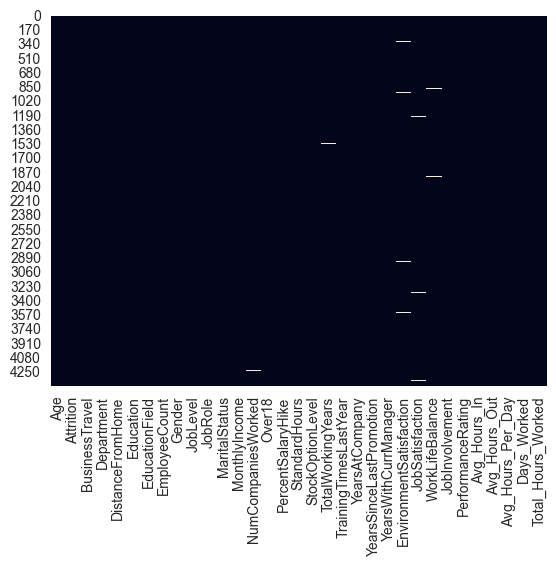

In [106]:
sns.heatmap(merged_data_copy.isna(), cbar=False)

In [107]:
(merged_data_copy.isna().sum()).sort_values(ascending=False)

WorkLifeBalance            38
EnvironmentSatisfaction    25
JobSatisfaction            20
NumCompaniesWorked         19
TotalWorkingYears           9
Avg_Hours_In                0
PerformanceRating           0
JobInvolvement              0
StockOptionLevel            0
Avg_Hours_Out               0
Avg_Hours_Per_Day           0
YearsWithCurrManager        0
YearsSinceLastPromotion     0
Days_Worked                 0
YearsAtCompany              0
TrainingTimesLastYear       0
Age                         0
StandardHours               0
Attrition                   0
PercentSalaryHike           0
Over18                      0
MonthlyIncome               0
MaritalStatus               0
JobRole                     0
JobLevel                    0
Gender                      0
EmployeeCount               0
EducationField              0
Education                   0
DistanceFromHome            0
Department                  0
BusinessTravel              0
Total_Hours_Worked          0
dtype: int

Très peu de NaN

### Analyse du fond

In [108]:
merged_data_copy['Attrition'].value_counts()

Attrition
No     3699
Yes     711
Name: count, dtype: int64

C:\Users\yoann\AppData\Local\Temp\ipykernel_19452\1230910706.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(merged_data[col])
C:\Users\yoann\AppData\Local\Temp\ipykernel_19452\1230910706.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(merged_data[col])
C:\Users\yoann\AppData\Local\Temp\

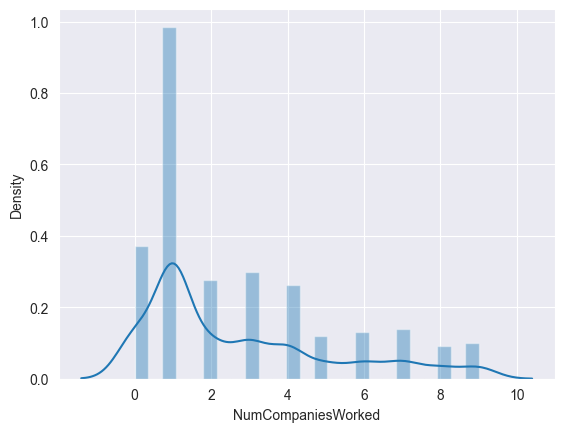

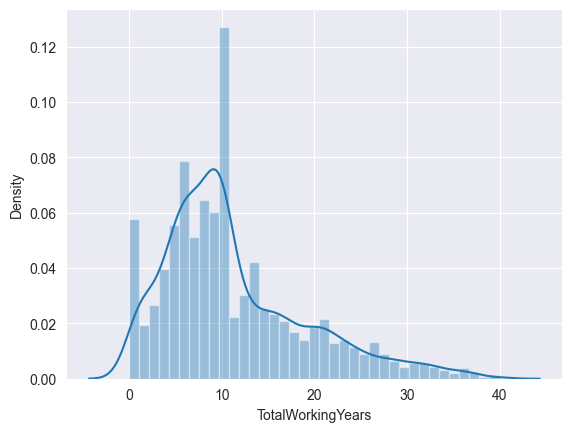

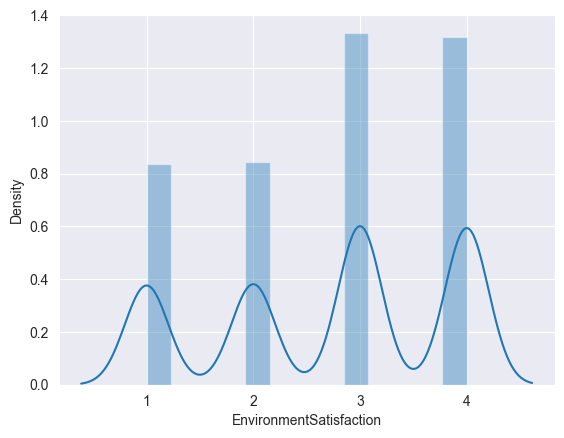

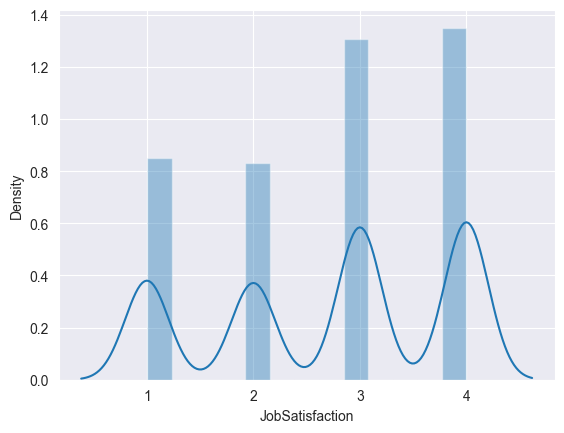

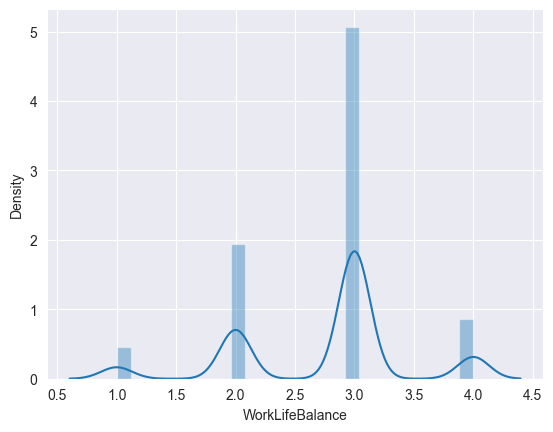

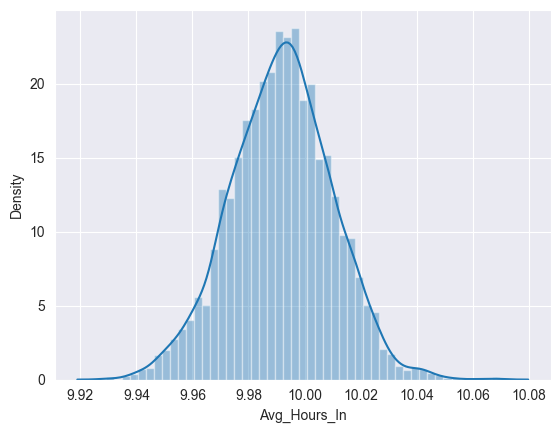

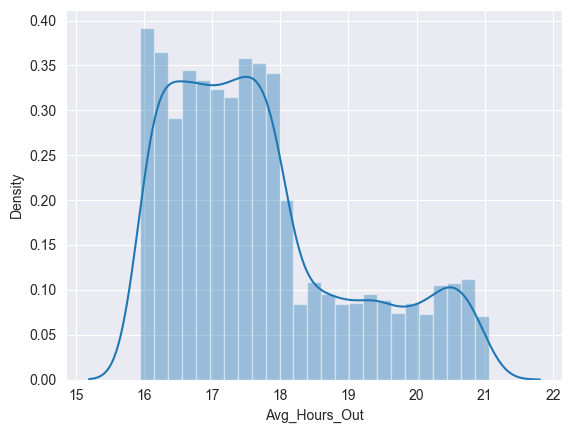

In [109]:
for col in merged_data_copy.select_dtypes('float'):
    plt.figure()
    sns.distplot(merged_data_copy[col])

In [110]:
for col in merged_data_copy.select_dtypes('object'):
    print(f'{col : <20} {merged_data_copy[col].unique()}')

Attrition            ['No' 'Yes']
BusinessTravel       ['Travel_Rarely' 'Travel_Frequently' 'Non-Travel']
Department           ['Sales' 'Research & Development' 'Human Resources']
EducationField       ['Life Sciences' 'Other' 'Medical' 'Marketing' 'Technical Degree'
 'Human Resources']
Gender               ['Female' 'Male']
JobRole              ['Healthcare Representative' 'Research Scientist' 'Sales Executive'
 'Human Resources' 'Research Director' 'Laboratory Technician'
 'Manufacturing Director' 'Sales Representative' 'Manager']
MaritalStatus        ['Married' 'Single' 'Divorced']
Over18               ['Y']
Avg_Hours_Per_Day    [7.373650622605362 7.718968926553678 7.013240358126724 ...
 7.7066317941317966 9.492594513600737 6.988947557471264]
Total_Hours_Worked   [1710.6869444444442 1821.6766666666679 1697.2041666666673 ...
 1780.231944444445 2287.715277777778 1621.4358333333332]


On remarque que Over18 n'a qu'une valeur et n'est donc pas utile

### Création de sous-ensembles positifs et négatifs

In [111]:
positive_data = merged_data_copy[merged_data_copy['Attrition'] == "no"]
negative_data = merged_data_copy[merged_data_copy['Attrition'] == "yes"]

<Axes: xlabel='MaritalStatus', ylabel='count'>

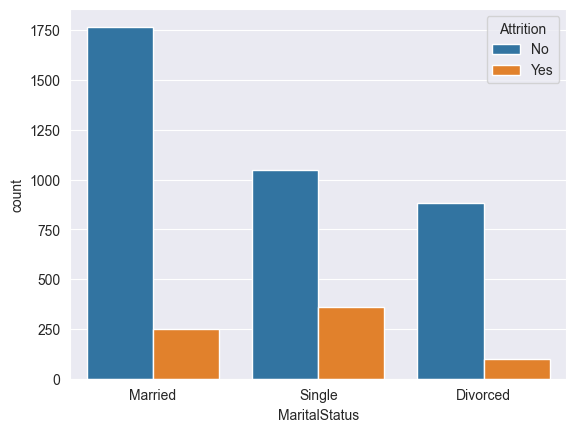

In [112]:
sns.countplot(x='MaritalStatus' ,hue='Attrition', data=merged_data_copy)

In [113]:
pd.crosstab(merged_data_copy['Attrition'], merged_data_copy['MaritalStatus'])

MaritalStatus,Divorced,Married,Single
Attrition,,,
No,882,1767,1050
Yes,99,252,360


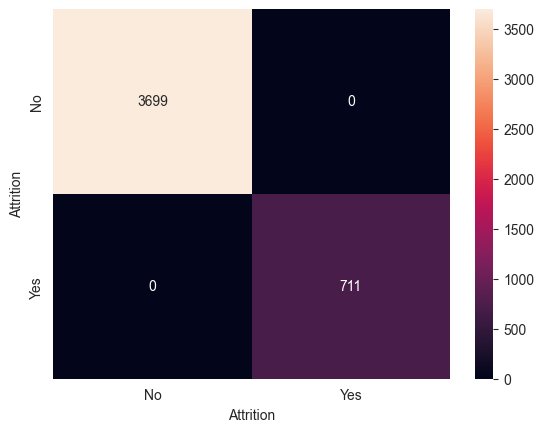

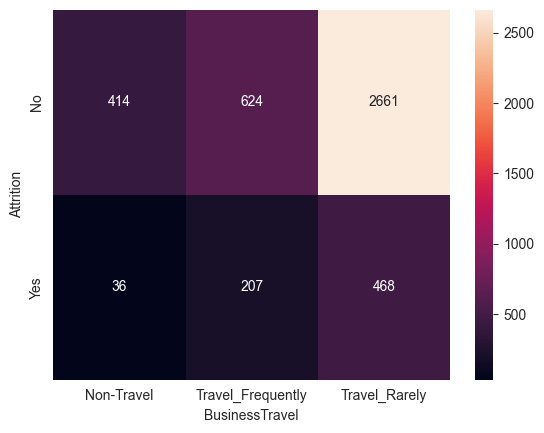

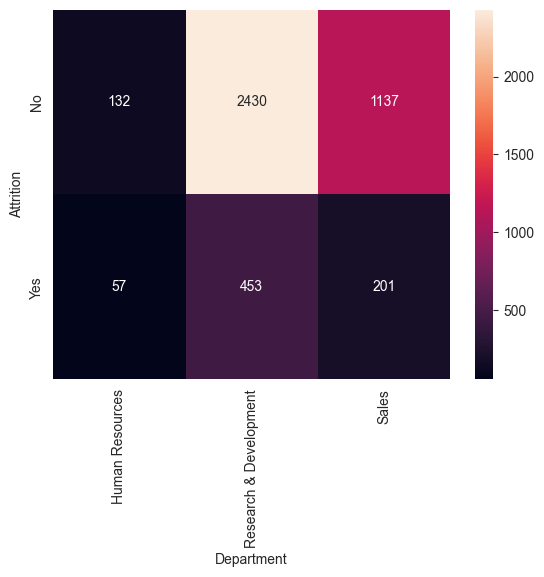

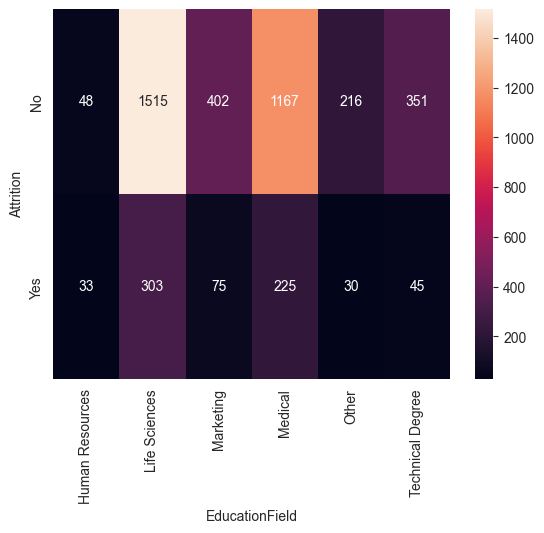

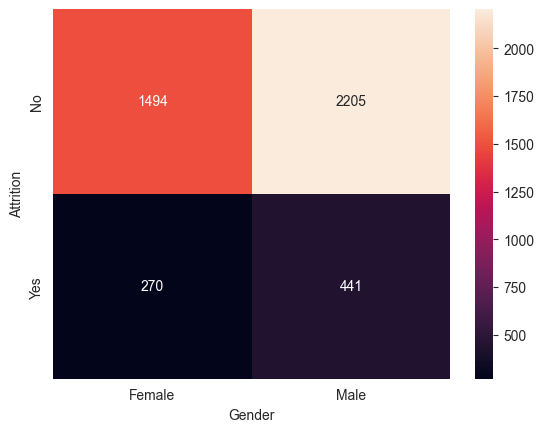

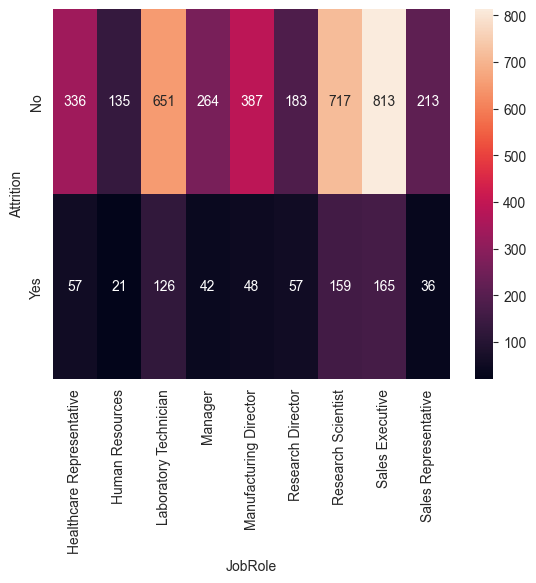

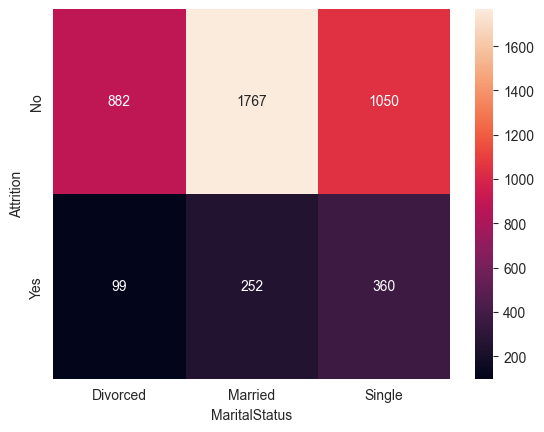

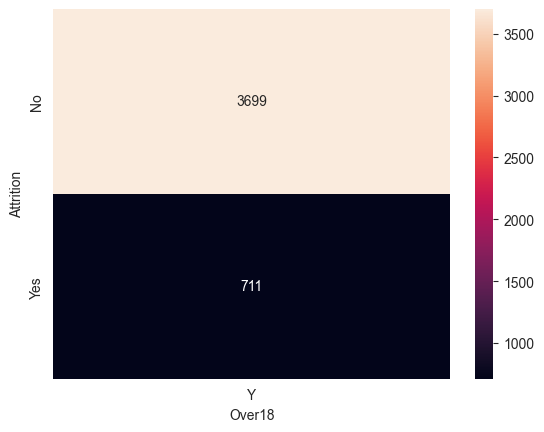

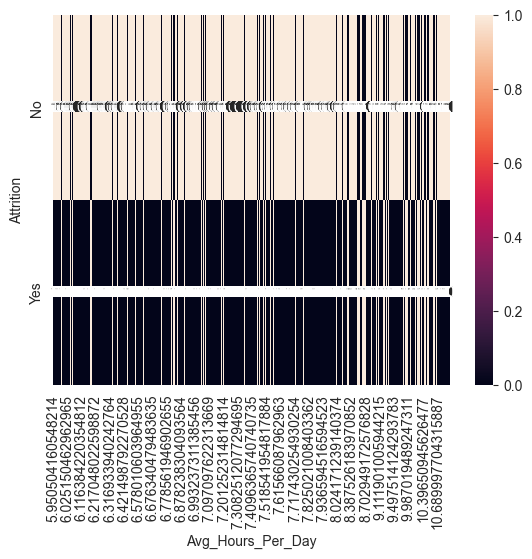

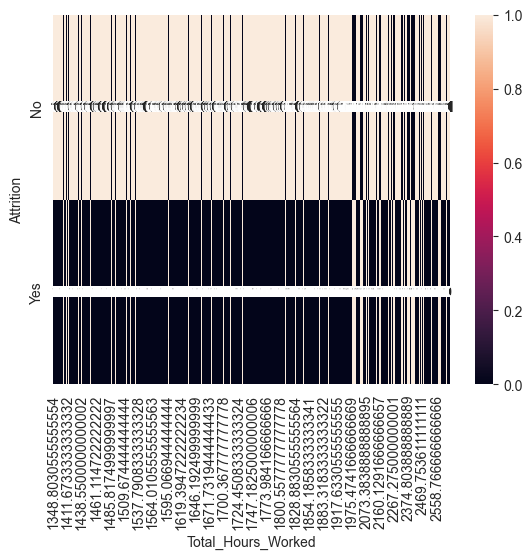

In [114]:
for col in merged_data_copy.select_dtypes('object'):
    plt.figure()
    sns.heatmap(pd.crosstab(merged_data_copy['Attrition'], merged_data_copy[col]), annot=True, fmt='d')

## Pre-Processing

In [ ]:
merged_data_copy = merged_data.drop('Attrition', axis=1)

## Elimination des NaN

In [49]:
numerical_features = make_column_selector(dtype_include=np.number)
categorical_features = make_column_selector(dtype_exclude=np.number)

numerical_transformer = Pipeline(steps=[
    ('imputer', KNNImputer(n_neighbors=5)),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = make_column_transformer((StandardScaler(), numerical_features),(OneHotEncoder(handle_unknown='ignore'), categorical_features))

preprocessor.fit_transform(X)

In [428]:
numerical_features = make_column_selector(dtype_include=np.number)
categorical_features = make_column_selector(dtype_exclude=np.number)

numerical_transformer = Pipeline(steps=[
    ('imputer', KNNImputer(n_neighbors=5)),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])

X_cleaned = pipeline.fit_transform(X)

print(X_cleaned.shape)

(4410, 8870)


In [430]:
X.head()

,Age,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeCount,Gender,JobLevel,JobRole,MaritalStatus,MonthlyIncome,NumCompaniesWorked,Over18,PercentSalaryHike,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,JobInvolvement,PerformanceRating,Avg_Hours_In,Avg_Hours_Out,Avg_Hours_Per_Day,Days_Worked,Total_Hours_Worked
0,51,Travel_Rarely,Sales,6,2,Life Sciences,1,Female,1,Healthcare Representative,Married,131160,1.0,Y,11,8,0,1.0,6,1,0,0,3.0,4.0,2.0,3,3,9.993032,17.367170,7.373651,232,1710.686944
1,31,Travel_Frequently,Research & Development,10,1,Life Sciences,1,Female,1,Research Scientist,Single,41890,0.0,Y,23,8,1,6.0,3,5,1,4,3.0,2.0,4.0,2,4,9.980720,17.698446,7.718969,236,1821.676667
2,32,Travel_Frequently,Research & Development,17,4,Other,1,Male,4,Sales Executive,Married,193280,1.0,Y,15,8,3,5.0,2,5,0,3,2.0,2.0,1.0,3,3,10.016598,17.030096,7.01324,242,1697.204167
3,38,Non-Travel,Research & Development,2,5,Life Sciences,1,Male,3,Human Resources,Married,83210,3.0,Y,11,8,3,13.0,5,8,7,5,4.0,4.0,3.0,2,3,9.973830,17.167305,7.193678,235,1690.514444
4,32,Travel_Rarely,Research & Development,10,1,Medical,1,Male,1,Sales Executive,Single,23420,4.0,Y,12,8,2,9.0,2,6,0,4,4.0,1.0,3.0,3,3,9.990068,17.996327,8.006175,245,1961.512778


### Encodage

In [419]:
encoder = OrdinalEncoder()
encoder.fit_transform(X_cleaned)

TypeError: Sparse data was passed, but dense data is required. Use '.toarray()' to convert to a dense numpy array.

### Normalisation

In [366]:
scaler = MinMaxScaler()
scaler.fit_transform(X)

ValueError: could not convert string to float: 'Travel_Rarely'